In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
import numpy as np
np.random.seed(44)


In [2]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    'figure.figsize': [12.0, 5.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Hierarchical models without predictors


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Based on 

* Alicia A. Johnson, Miles Q. Ott, Mine Dogucu, Bayes Rules! An Introduction to Applied Bayesian Modeling, Chapter 16,  *Hierarchical Models without Predictors*, https://www.bayesrulesbook.com/chapter-16.html

* Some images are indeed taken  from that book. 

# Our first hierarchical models: songs popularity

* We assume to have the response variable $Y$, but no predictors $X$. 

* Spotify  provides a data bases of songs and their *popularity* score,  which a rating  on tje 0-100 scale. 
* In general, the more recent the plays of the  song has on the platform, the higher its popularity rating. 

# Research questions 


*    What’s the typical popularity of a Spotify song?
*   To what extent does popularity vary from artist to artist?
*   For any single artist, how much might popularity vary from song to song?

* A priori we can expect the average popularity rating to be around 50; apart from that, we don’t have any strong prior information.

In [3]:
# the full data set is available from the bayesrule package for R. This is a reduced version which only contains song, author and popularity.
#The data set contains 350 songs by 44 artists
spotify = pd.read_csv("data/spotify.csv")

spotify

,artist,title,popularity
0,Alok,On & On,79
1,Alok,All The Lies,56
2,Alok,Hear Me Now,75
3,Alok,The Wall,65
4,Alok,Hear Me Now,52
...,...,...,...
345,Zeds Dead,Frontlines,58
346,Zeds Dead,Stardust,44
347,Zeds Dead,Save My Grave,54
348,Zeds Dead,Shake,49


# Hierarchical data set

The data set is hierarchical:

* it comprises  multiple songs for each of 44 artists 
* the artists  were sampled from the population of all artists that have songs on Spotify 

<img src='img/spotify-hierarchical-data-diagram.png' width=600 align="center" >



In [4]:
# Mean popularity of the songs of each artist.
# There are major differences between authors, both in the number of produced songs and in their  popularity.

artist_popularity=spotify.groupby(['artist']).mean().sort_values('popularity')
artist_popularity

,popularity
artist,
Mia X,13.250000
Chris Goldarg,16.400000
Soul&Roll,24.200000
Honeywagon,31.666667
Röyksopp,33.250000
Freestyle,33.666667
DA Image,36.666667
Jean Juan,36.800000
TV Noise,38.142857


In [5]:
# Number of the songs of each artist, which varies between 2 and 40.
artist_count=spotify.groupby(['artist']).count().sort_values('popularity')
artist_count

,title,popularity
artist,,
Sean Kingston,2,2
David Lee Roth,3,3
Lil Skies,3,3
Tamar Braxton,3,3
Honeywagon,3,3
Michael Kiwanuka,3,3
Freestyle,3,3
The Wrecks,3,3
Elisa,3,3


# The structure of the data

* We use $i$ and $j$ subscripts to denote the $j$-th  artist and its  $i$-th song.
* $n_j$ is  the number of songs of  artist $j$ , $j \in  \{1,2,…,44\}$. 
*  $Y_{ij}$  represents the $i$-th song of artist $j$, where $i \in \{1,2,…,n_j\}$ and $j \in \{1,2,…,44\}$.

* The sample of 350  songs is the collection of 44 smaller samples, one for  each artist:

$Y := \left((Y_{11}, Y_{21}, \ldots, Y_{n_1,1}), (Y_{12}, Y_{22}, \ldots, Y_{n_2,2}), \ldots, (Y_{1,44}, Y_{2,44}, \ldots, Y_{n_{44},44})\right)  $

# Three different modelling approaches

* *Complete pooling*: ignore artists and lump all songs together

* *No pooling*:  analyze each artist independently.

* *Partial pooling* via hierarchical model. Model the population of  artists and the population of songs from each artist;  share  information about different artistist, to obtain more robust estimates for artists which few songs.

# Complete pooling 

* The complete pooled model ignores the clustering (or *grouping*) structure implied by the different authors.
*  It treats  all songs as a sample from the same population, without modelling the sub-populations (due to the different authors).
* As a simplifying assumption,  we assume  the ratings to be normally distributed, even if they are  somewhat left skewed.

<img src='img/spotify-density.png' width=400 align="center" >

# Quiz your self

* What would be the  prediction of the completely pooled model for:

    * a new song of  Mia X, the artist with the lowest mean popularity  (13) ? 
    * Beyoncé, the artist with nearly the highest mean popularity in our sample (70)?
    * Mohsen Beats, a group not present in the sample?




# Answer
* The  complete pooled model ignores the artist-specific information.
* It  predicts the same  popularity for any new song of  every artist.

# Normal-normal model

* The Normal-normal model has a likelihood which is normal and a prior which is also normal.


* The popularity of every song is a draw from a normal distribution $N(\mu,\sigma)$.  Thus $\mu$ and $\sigma$ are shared by every song; those are  *global* parameters which do not vary by artist.

* $\mu$: global mean of the popularity
* $\sigma$: global standard deviation of the popularity, expressing variability  from song to song.

* A priori, our beliefs about the global mean is that it is around 50, but we are uncertain about it. Our uncertainty in this can be represent by saying that with probability 68% the global mean lies within (25, 75), in which the standard deviation of our prior is 25. Of course different choices are also plausible. The current speciation allows the mean to vary in (-25, 125), i.e. beyond the actual limits.

* We also set a broad prior on $\sigma$. 

* **fare vedere che queste prior possono essere decise campionando rv e poi guardando i quantili**

\begin{equation}
\begin{split}
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma) \\
\mu    & \sim N(50, 25) \\
\sigma & \sim HalfNormal (20) \\
\end{split}
\tag{16.1}
\end{equation}

In [6]:
with pm.Model() as pooled_model:
    # prior
    global_mean     =   pm.Normal ('global_mean', 50,  25)
    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 20)

    #likelihood
    popularity          =  pm.Normal ('popularity', mu = global_mean,  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_pooled     = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, global_mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [7]:
# The posterior summary shows  that Spotify songs have an average popularity of about 58; 
# there is  a relatively large standard deviation from song to song of about 20 points.
# Thus the popularity of about 68% of the songs is estimated to be in 58+-20=[38, 78].
# Thus the popularity of about 95% of the songs is estimated to be in 58+-40=[08, 98].
az.summary(trace_pooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mean,58.386,1.103,56.290,60.435,0.018,0.013,3678.0,2985.0,1.0
global_sigma,20.679,0.792,19.232,22.154,0.013,0.009,3912.0,2764.0,1.0


# Computing the prediction 

* We have the posterior samples of the global mean $\mu$ and of the global $\sigma$. 
* The parameters are shared across all artists, thus the same prediction holds for every artist.
* We cannot however make predictions for artists which are not already present in the data set.

# Computing the prediction 

* For each sampled pair $<\mu_s, \sigma_s>$
    * For $i$ =1,2,...100 (different realization of the noise):
   $$ y_{s,i} = \mu_s + N(0,    \sigma_s)$$
   
Eventually, merge  the $y_{s,i}$ to have the posterior distribution of $y$, accouting for the uncertainty over $\mu$, $\sigma$, noise realization.


In [8]:


with pooled_model:
    # this function sets the test data (structured as a dict) in correspondence of which to compute the prediction.
    # But our model has no feature, hence the list of test values is empty. We make a predition on popularity using its posterior distribution.
    # In this way we account for our uncertainty on the estimate of the parameters.
    pm.set_data({})
    # the posterior_predictive function implements the probabilistic prediction of the previous slide
    y_test = pm.sample_posterior_predictive(trace_pooled, samples=1000)

az.summary(y_test)

/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (350). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
popularity,58.382,20.716,19.137,97.093,0.035,0.025,354018.0,352454.0,1.0


# Unpooled model

* This model independently analyzes the popularity of each artist.

* The mean popularity $\mu_j$ is different for each artist.
* For each artist, we assume that the popularity of the different songs  are normally distributed $N(\mu_j, \sigma)$:
* The variability in popularity from song to song is the same for each artist, and hence $\sigma$ lacks the  $j$ subscript.
    




# Unpooled model

   * $\mu_j$ = mean song popularity for artist $j$
   * $\sigma$:  standard deviation of popularity from song to song within each artist.


<img src='img/spotify-unpooled.png' width=400 align="center" >

# Unpooled model

* Every song $i$ by the same artist $j$, $Y_{ij}$, shares mean parameter $\mu_j$
* Songs by different artists $j$ and $k$  have different independent mean parameters $\mu_j$ and $\mu_k$.
* One artist’s mean doesn’t tell us anything about another’s.
* The model assumes that the artists share the same $\sigma$: it does pool information from the artists to learn about it.
* The shared standard deviation simplifies model fitting.

# Unpooled model
\begin{align}
\mu_j    & \sim N(50, s_{\mu}^2) \\
\sigma & \sim \text{HalfNormal}(0.048) \\
Y_{ij} | \mu_j, s_{\mu} & \sim N(\mu_j, \sigma^2) \\
\end{align}

In [9]:
n_artist = len(artist_count) #44

#array of string with the name
artist       = spotify['artist'].values

#assign a numerical code to each author.
#maps the first author to 0, the second author to 1, etc.
spotify['artist_code']  = spotify['artist'].astype('category').cat.codes
spotify['artist_code']

0       0
1       0
2       0
3       0
4       0
       ..
345    43
346    43
347    43
348    43
349    43
Name: artist_code, Length: 350, dtype: int8

In [10]:
n_artist = len(artist_count) #44

with pm.Model() as unpooled_model:
    # We have a vector of means, one for each artist. 
    # We want to estimate the mean of each author independently. 
    # Thus we assign to each author the same prior, which will be updated into a posterior independently from the other means.
    mean            =  pm.Normal ('mean', 50,  25, shape= n_artist)
    global_sigma    =  pm.HalfNormal ('global_sigma', sd = 20)

    #likelihood. A different mean for  each artist is inferred 
    popularity      =  pm.Normal ('popularity', mu = mean[spotify['artist_code']],  sigma = global_sigma, observed = spotify["popularity"])
    
    trace_unpooled  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_sigma, mean]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [11]:
# one mean for each artisti
az.summary(trace_unpooled)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean[0],64.559,3.215,58.428,70.479,0.034,0.024,9253.0,2802.0,1.00
mean[1],46.082,6.544,33.166,57.752,0.071,0.052,8523.0,3207.0,1.00
mean[2],60.254,6.015,48.601,71.219,0.057,0.041,11252.0,2570.0,1.00
mean[3],43.014,7.723,28.593,57.950,0.074,0.056,10744.0,3010.0,1.00
mean[4],69.490,2.808,64.002,74.642,0.029,0.021,9061.0,2624.0,1.00
mean[5],49.143,5.496,37.991,58.563,0.059,0.042,8634.0,2736.0,1.00
mean[6],50.431,6.727,37.642,63.089,0.065,0.046,10646.0,2839.0,1.00
mean[7],76.861,2.331,72.663,81.396,0.024,0.017,9142.0,2460.0,1.01
mean[8],79.971,4.583,71.342,88.599,0.046,0.032,10044.0,2627.0,1.00
mean[9],17.439,4.387,9.315,25.474,0.050,0.037,7694.0,2894.0,1.00


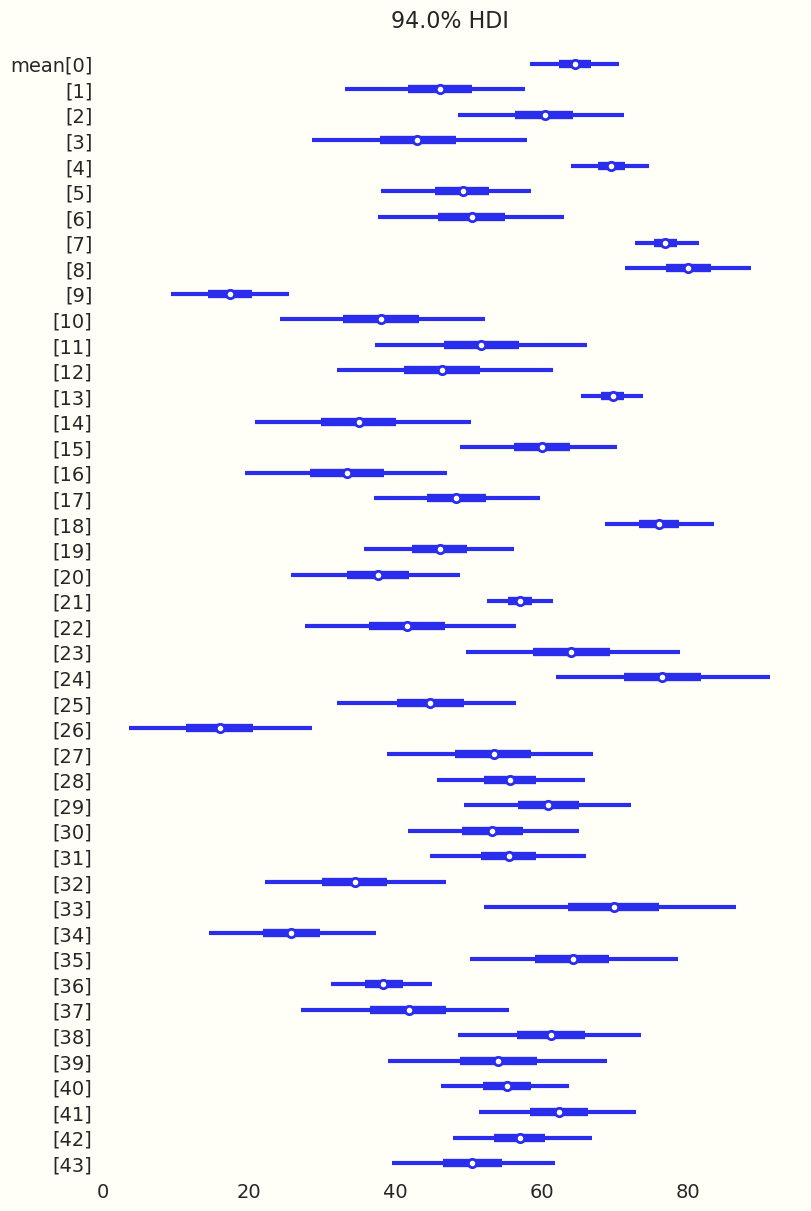

In [12]:
#graph could be refined setting labels on the y axis, as in https://arviz-devs.github.io/arviz/user_guide/label_guide.html
axes = az.plot_forest (trace_unpooled,  kind='forestplot', var_names="mean", combined=True, figsize=(8,12));

# Discussion

* The no pooled model acknowledges that some artists tend to be more popular than others.
* Yet, it  ignores data from the population of  artists. This is especially problematic when it comes to artists for whom we have few data points. For example, our low posterior predictions for Mia X’s next song were based on a measly 4 songs. The other artists’ data suggests that these low ratings might just be a tough break – her next song might be more popular! Similarly, our high posterior predictions for Lil Skies’ next song were based on only 3 songs. In light of the other artists’ data, we might wonder whether this was beginner’s luck that will be tough to maintain.

# Artists out of sample

* The  model cannot be applied to artists outside our sample.
*  The no pooled model is tailor-made to the artists in our sampl
* Even if we do have data about various artists, the model tell us nothing about  artists that didn’t make it into our sample.

# Hierarchical model

\begin{equation}
\begin{array}{lrl}
\text{Layer 1:} & \hspace{-0.05in} Y_{ij} | \mu_j, \sigma_y   & \hspace{-0.075in} \sim \text{model of how song popularity varies WITHIN artist } j \\
\text{Layer 2:} & \hspace{-0.05in} \mu_j | \mu, \sigma_\mu & \hspace{-0.075in} \sim \text{model of how the typical popularity $\mu_j$ varies BETWEEN artists}\\
\text{Layer 3:} & \hspace{-0.05in} \mu, \sigma, \sigma_\mu  & \hspace{-0.075in} \sim \text{prior models for shared global parameters} \\
\end{array}
\end{equation}

# Level 1: individual songs for each artist.

* For  artist $j$, we assume that the popularity of songs $i$ is normally distributed with mean $μ_j$ and standard deviation $σ_y$
* The shared $σ_y$, which is common among all artists, simplifies the sampling of the model; an alternative parameterization with a different $\sigma_j$ for each artist could be also implemented however.
$$  Y_{ij} \sim N(\mu_j, \sigma_y) $$

# Level 2: modeling the population of artists

* If we  place separate priors on each $\mu_j$, we obtain the no-pooled model.
* Layer 2 is where the hierarchical model is different. 
* Layer 2 acknowledges that the 44 sampled artists are  drawn from the same population of Spotify artists. 
* Within this population, popularity varies from artist to artist.
* Yet, we can consider the  $μ_j$ as sampled from the population of the mean popularity of artists:
$$ \mu_j \sim N(\mu, \sigma_{\mu}) $$

# Level 2: modeling the population of artists

$$ \mu_j \sim N(\mu, \sigma_{\mu}) $$

* $\mu$ :  global average of mean popularities within the population of artists
* $\sigma_\mu$ :  standard deviation in mean popularity μj from artist to artist.

# Notation alert

* Notice the  difference between $μ_j$ (mean of the j-th artist) and $\mu$ (mean of the population of artists).

* When a parameter has a subscript $j$, it refers to a group $j$; when it has no subscript, it is global, i.e., it refers to  the whole population of artists.

* $\sigma_y$ refers to the standard deviation of $Y$ values within each group. 
* $\sigma_{\mu}$ refers to the standard deviation of the means $\mu_j$ within the population of artists.

# Layer 3: priors for the global parameters $\mu, \sigma_{\mu}, \sigma_y$

\begin{align}
\mu           & \sim N(50, 20) & \text{(implies a range of +- 60 around 50)} \\
\sigma      & \sim \text{Half Normal}(15) & \text{(discussed in next slide)}     & \\
\sigma_\mu & \sim \text{Half Normal}(6)    & \text{(uncertainty in the location of the global mean)}  \\
\end{align}

In [13]:
# how to choose the priors on standard deviation
# assume that the popularity of the songs of a  given artist (sigma_y) span a range of about 50 point
# 50 / 3 is around 17, which is a plausible though large value of sigma.
# We make sure that our half normal prior covers values which are also quite far from this guess.
# To check that our prior is sensible, we sample 10000 values from the prior and checks the distribution.
# Below we implement the halfNormal as the abs of random normal.

pd.DataFrame(np.abs(np.random.normal(0, scale=15, size=10000))).describe()

,0
count,10000.000000
mean,12.033872
std,9.111312
min,0.000686
25%,4.731771
50%,10.219122
75%,17.488047
max,55.195757


In [14]:
n_artist = len(artist_count) #44

with pm.Model() as hier_model:
    
    # layer 1: prior on the parameters of the population of artists (hyper-priors). 
    # prior beliefs about the location of the mean popularity, within the population of artists
    mu              = pm.Normal ('mu', 50,  20)
    sigma          = pm.HalfNormal ('sigma', 15)
    sigma_mu = pm.HalfNormal ('sigma_mu', 6)
    
    # layer 2: model of the population of artists.
    mean       =  pm.Normal ('mean', mu,  sigma_mu, shape= n_artist)
    sigma_y   = pm.HalfNormal ('sigma_y', sd = sigma)

    #layer 3 (observation specific for each artist)
    popularity      =  pm.Normal ('popularity', mu = mean[spotify['artist_code']],  sigma = sigma_y, observed = spotify["popularity"])
    
    trace_hier  = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, mean, sigma_mu, sigma, mu]


/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/giorgio/opt/anaconda3/envs/bda/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


# analysis of variance from book

# Parameters
* The hierarchical Spotify model  has  47 parameters:
    * 44 artist-specific parameters $mu_j$
    * 3 global parameters $\mu, \sigma_y,  \sigma_\mu\$.

In [15]:
az.summary(trace_hier)[ ["mean","hdi_3%","hdi_97%","r_hat"]]

,mean,hdi_3%,hdi_97%,r_hat
mu,52.504,48.095,56.827,1.00
mean[0],64.149,58.173,69.807,1.00
mean[1],47.053,34.516,57.925,1.00
mean[2],59.399,48.163,70.582,1.00
mean[3],44.953,31.669,58.708,1.00
mean[4],68.995,63.942,74.130,1.00
mean[5],49.643,39.772,59.040,1.00
mean[6],51.051,38.959,62.234,1.00
mean[7],76.441,72.421,80.826,1.00
mean[8],78.103,69.020,85.988,1.00


In [16]:

#we analyze the model step by step
# there is about 95% probability of the mean popularity of an artist being between about 48 and 57
az.summary(trace_hier, var_names="mu")[ ["mean","hdi_3%","hdi_97%","r_hat"]]

,mean,hdi_3%,hdi_97%,r_hat
mu,52.504,48.095,56.827,1.0


array([<AxesSubplot:>], dtype=object)

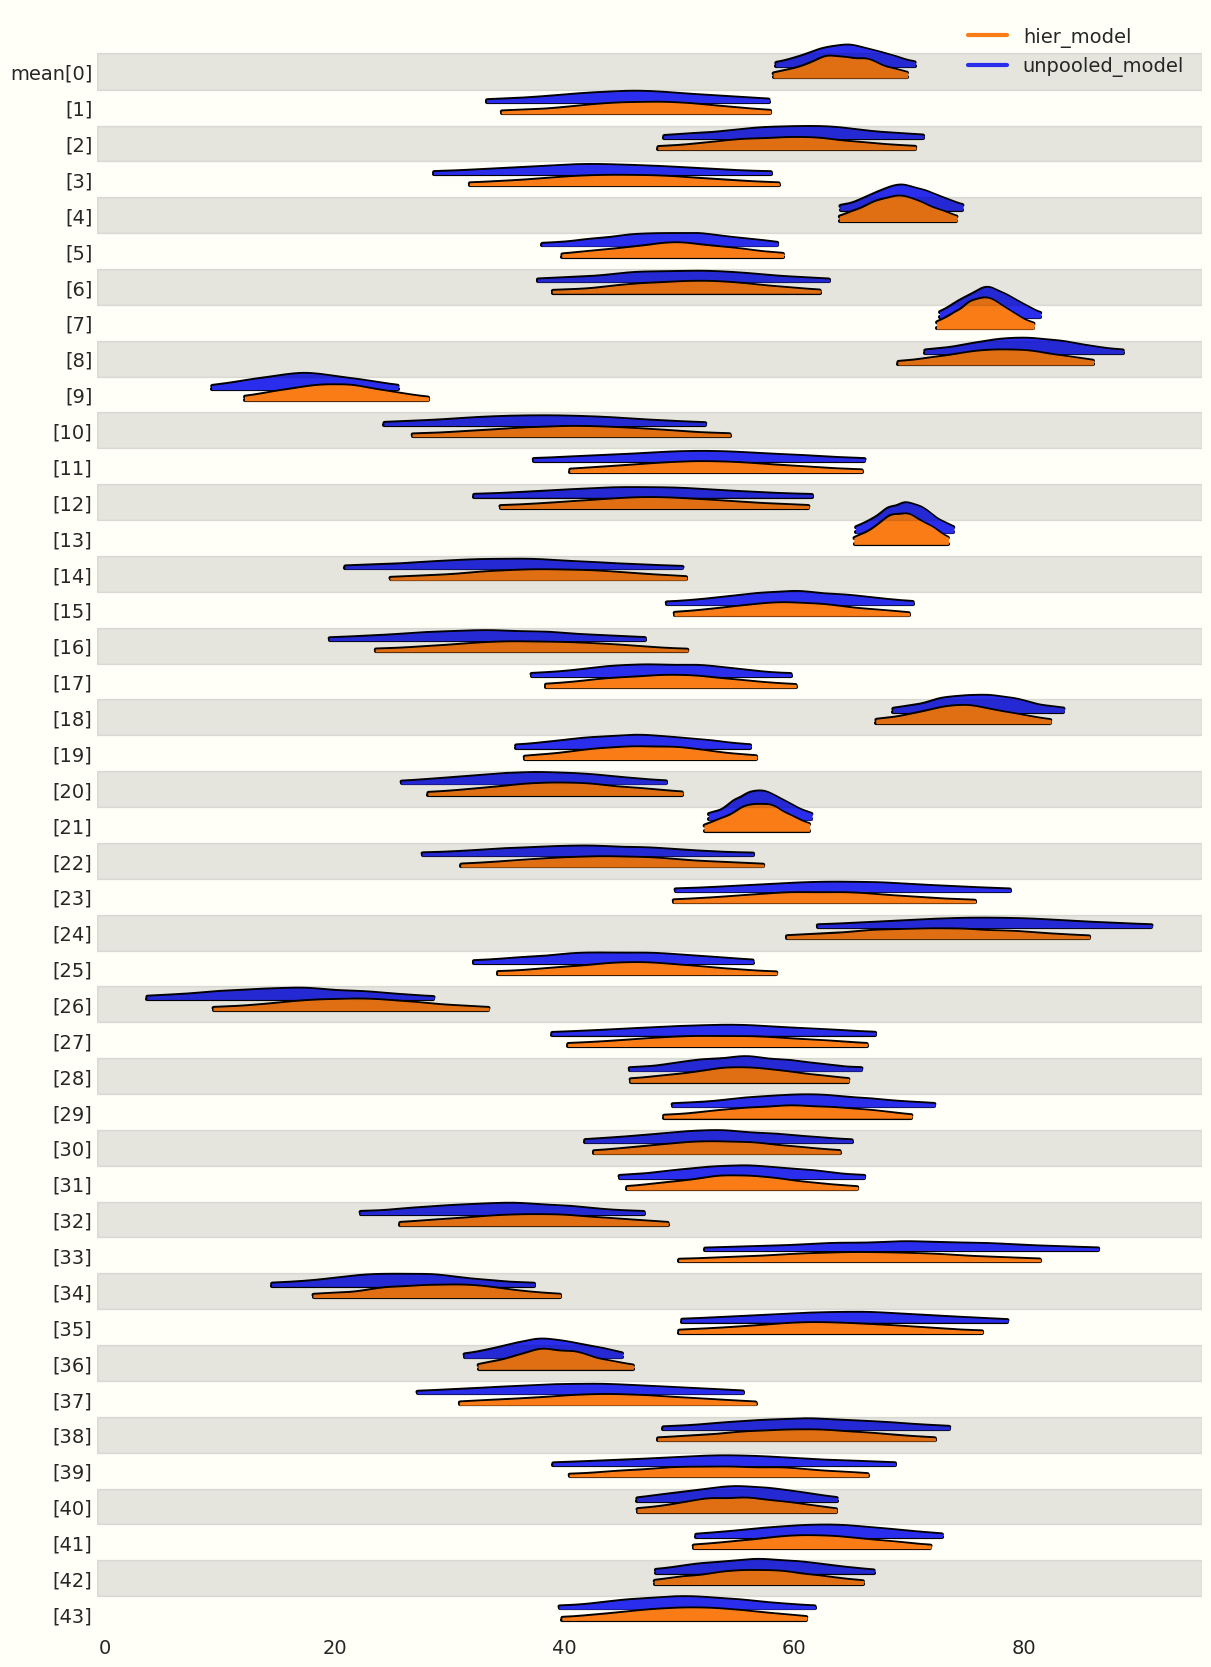

In [44]:
az.plot_forest([trace_unpooled, trace_hier], model_names=['unpooled_model', 'hier_model'], combined=True, kind='ridgeplot', var_names='mean')

In [23]:
az.plot_forest?

In [37]:
a=az.summary(trace_unpooled)[["mean","sd"]]
b=az.summary(trace_hier)[["mean","sd"]]
c=pd.concat([a,b], axis=1)
#and sort by sd

,mean,sd,mean,sd
mean[0],64.559,3.215,64.149,3.140
mean[1],46.082,6.544,47.053,6.225
mean[2],60.254,6.015,59.399,5.956
mean[3],43.014,7.723,44.953,7.151
mean[4],69.490,2.808,68.995,2.747
mean[5],49.143,5.496,49.643,5.189
mean[6],50.431,6.727,51.051,6.184
mean[7],76.861,2.331,76.441,2.237
mean[8],79.971,4.583,78.103,4.568
mean[9],17.439,4.387,19.792,4.287


In [41]:
az.plot_forest?

# Aggiungere un notebook WAIC!